<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/15min_Grid_Test_Knock_In_Call_3stocks_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [3]:
import pandas as pd

In [4]:
nstock = 3
model_save_name = f'jax_knock_in_{str(nstock)}stocks_1.pth'

# Dataset generation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import cupy
# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# import pandas as pd
# from torch.utils.dlpack import from_dlpack

# def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
#     stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
#     stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
#                             jax.ops.index[0],         # initialization of stock prices
#                             initial_stocks)
#     noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
#     sigma = jnp.diag(cov) ** 0.5
#     dt = T / numsteps
#     def time_step(t, val):
#         dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
#         val = jax.ops.index_update(val,
#                             jax.ops.index[t],
#                             val[t-1] * dx)
#         return val
#     return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

# def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
#     out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
#     knock_in_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
#     r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_in_index]/(knock_in_index+1)

#     return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
#                     (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_in_index] - K) *   # (S[knock-in]-K)
#                     jnp.exp(- r_mean_array * (T * (knock_in_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

# goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

# #################################################################### Adjust all parameters here (not inside class)
# numstocks = 3
# numsteps = 50
# numpaths = 2000000

# rng = jax.random.PRNGKey(np.random.randint(10000))
# rng, key = jax.random.split(rng)
# keys = jax.random.split(key, numpaths)

# S1_range = jnp.linspace(0.75, 1.25, 6)[2:4]
# S2_range = jnp.linspace(0.75, 1.25, 6)
# S3_range = jnp.linspace(0.75, 1.25, 6)
# K_range = jnp.linspace(0.75, 1.25, 5)
# B_range = jnp.linspace(1.1, 1.6, 6)
# sigma_range = jnp.linspace(0.15, 0.45, 3)
# r_range = jnp.linspace(0.01, 0.04, 3)
# T = 1.0

# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
# ####################################################################

# call = []
# count = 0

# for S1 in S1_range:
#   for S2 in S2_range:
#     for S3 in S3_range:
#       for K in K_range:
#         for B in B_range:
#           for r in r_range:
#             for sigma in sigma_range:

#               initial_stocks = jnp.array([S1, S2, S3]) # must be float
#               r_tmp = jnp.array([r]*numsteps)
#               drift = jnp.array([r]*numstocks)
#               cov = jnp.identity(numstocks)*sigma*sigma

#               Knock_In_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)
#               Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)
#               call.append([T, K, B, S1, sigma, r, r,
#                           T, K, B, S2, sigma, r, r,
#                           T, K, B, S3, sigma, r, r, Knock_In_Call_price] + list(Deltas)) #T, K, B, S, sigma, mu, r, price, delta
              
#               count += 1
#               print(count)


# Thedataset = pd.DataFrame(call)

# #save to csv
# Thedataset.to_csv(f'/content/drive/MyDrive/AFP/Save_Models/Knock_In_Call_{str(nstock)}stocks_Datset_part{part}.csv', index=False, header=False)

# Access to the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read csv
Thedataset = pd.read_csv(f'/content/drive/MyDrive/AFP/Save_Models/Knock_In_Call_{str(nstock)}stocks_Datset.csv', header=None)

# Construct Neural Net

In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:7*nstock]
Thedataset_Y = Thedataset.iloc[:,7*nstock:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
# ds = OptionDataSet(max_len = 1)
# for i in ds:
#     print(i[0])
#     print(i[0].shape)
#     print(i[1])
#     print(i[1].shape)

In [1]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024, nstock = 1):
        self.nstock = nstock
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*self.nstock, 64) # remember to change this!
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, nstock + 1) # outputs: prices, delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03] * self.nstock)) # don't use numpy here - will give error later
                                                                               # T, K, B, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 1.1, 0.75, 0.15, 0.01, 0.01] * self.nstock).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 5.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net(nstock = nstock).cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y_pred.shape)

    loss_weight = torch.tensor([1] * (nstock+1)).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 1000)

# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  """


loss 0.004969609751048398 average time 0.01651886645000502 iter num 20
loss 0.003386017726663996 average time 0.012826888925005164 iter num 40
loss 0.0027154252648647114 average time 0.011603527233337256 iter num 60
loss 0.002488932975223694 average time 0.01098057447500338 iter num 80
loss 0.002447251639210008 average time 0.010626100830003225 iter num 100
loss 0.0019424159474947067 average time 0.009227751099999182 iter num 20
loss 0.0017384935106988346 average time 0.009200453374999995 iter num 40
loss 0.001671712958565473 average time 0.009200638499999058 iter num 60
loss 0.0016532050338761736 average time 0.009198519537498128 iter num 80
loss 0.001649917523564574 average time 0.00919638183999723 iter num 100
loss 0.0016027062815502642 average time 0.009173974799998064 iter num 20
loss 0.0015740257397097307 average time 0.00915328869999854 iter num 40
loss 0.0015562304794637747 average time 0.009138472766665965 iter num 60
loss 0.001548037271932845 average time 0.009144638424998418

In [ ]:
# 15min

**Save Model**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import torch
# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch
# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/Grid PTH/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [7]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net(nstock = nstock).cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=21, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=4, bias=True)
)


**Continue to train model**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# from ignite.engine import Engine, Events
# from ignite.handlers import Timer
# from torch.nn import MSELoss
# from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
# from ignite.handlers import ModelCheckpoint
# from model import Net
# import numpy as np
# import torch
# from torch import Tensor
# from torch.autograd import grad
# timer = Timer(average=True)
# #model = Net(nstock = nstock).cuda()
# loss_fn = MSELoss()
# optimizer = Adam(model.parameters(), lr=1e-3, eps=1e-4, amsgrad=True) # try using higher epsilon and amsgrad
# dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

# def train_update(engine, batch):
#     model.train()
#     optimizer.zero_grad()
#     x = batch[0]
#     y = batch[1]
#     y_pred = model(x.float())

#     loss_weight = torch.tensor([1] * (nstock+1)).cuda()
#     loss_weight_normalized = loss_weight/loss_weight.sum()
#     loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

#     loss.backward()
#     optimizer.step()
#     return loss.item()

# trainer = Engine(train_update)
# log_interval = 20

# scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
# trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
# timer.attach(trainer,
#              start=Events.EPOCH_STARTED,
#              resume=Events.ITERATION_STARTED,
#              pause=Events.ITERATION_COMPLETED,
#              step=Events.ITERATION_COMPLETED)    
# @trainer.on(Events.ITERATION_COMPLETED)
# def log_training_loss(engine):
#     iter = (engine.state.iteration - 1) % len(dataset) + 1
#     if iter % log_interval == 0:
#         print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
# trainer.run(dataset, max_epochs = 500)

# model_save_name = model_save_name[:-4] + '_continue.pth'
# path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
# torch.save(model.state_dict(), path)

loss 4.07327855902533e-07 average time 0.013607025399960549 iter num 20
loss 4.0730674054522467e-07 average time 0.013391080674966815 iter num 40
loss 4.072937739898336e-07 average time 0.013276590399967366 iter num 60
loss 4.072889137704212e-07 average time 0.013214313237483566 iter num 80
loss 4.0728839340699005e-07 average time 0.013183421699973224 iter num 100
loss 4.072651539276643e-07 average time 0.012971756250021827 iter num 20
loss 4.0724457905011304e-07 average time 0.012985742900025344 iter num 40
loss 4.0723213170368456e-07 average time 0.012961845383339702 iter num 60
loss 4.072271633345118e-07 average time 0.012978152499994167 iter num 80
loss 4.072267933579055e-07 average time 0.01301287151998622 iter num 100
loss 4.0720342615635475e-07 average time 0.013040209549967586 iter num 20
loss 4.0718407564926974e-07 average time 0.012966067924969593 iter num 40
loss 4.071717134277216e-07 average time 0.012991657083315051 iter num 60
loss 4.071670846843311e-07 average time 0.013

In [ ]:
# 10min

#Results

In [9]:
# Knock in call
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_in_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_in_index]/(knock_in_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_in_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_in_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 3
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

K = 0.75
T = 1.0
r = 0.02
sigma = 0.25
B = 1.15
initial_stocks = jnp.array([1.]*numstocks) # must be float
r_tmp = jnp.array([r]*numsteps)
drift = jnp.array([r]*numstocks)
cov = jnp.identity(numstocks)*sigma*sigma

fast_simple = jax.jit(Brownian_motion, static_argnums=2)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
# print(optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)) # here numsteps different from T

# delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)) # here numsteps different from T

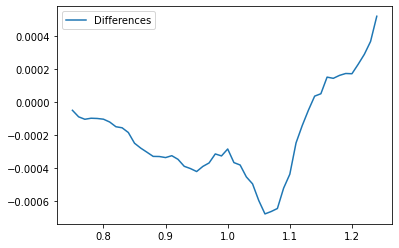

In [18]:
import matplotlib.pyplot as plt
import numpy as np

B = 1.15
s1 = 1.
s3 = 0.875

def compute_price(S):
    inputs = torch.tensor([[1, 0.75, B, s1, 0.25, 0.02, 0.02] + [1, 0.75, B, S, 0.25, 0.02, 0.02] + [1, 0.75, B, s3, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][0]

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
correct_call_prices = []
for p in prices:
    initial_stocks = jnp.array([s1, p, s3]) # must be float
    model_call_prices.append(compute_price(p).item())
    correct_call_prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, 0.75, B, T, numpaths))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, correct_call_prices, label = "JAX_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(correct_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

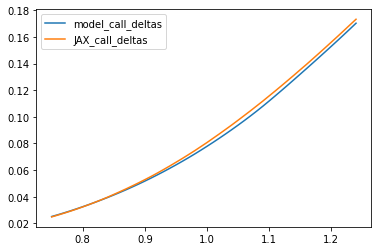

In [29]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.15

def compute_delta(S):
    inputs = torch.tensor([[1, 0.75, B, s1, 0.25, 0.02, 0.02] + [1, 0.75, B, S, 0.25, 0.02, 0.02] + [1, 0.75, B, s3, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([s1, p, s3]) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, 0.75, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

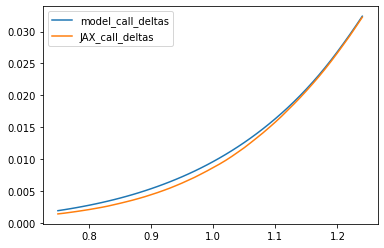

In [30]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.35

def compute_delta(S):
    inputs = torch.tensor([[1, 0.75, B, s1, 0.25, 0.02, 0.02] + [1, 0.75, B, S, 0.25, 0.02, 0.02] + [1, 0.75, B, s3, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([s1, p, s3]) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, 0.75, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

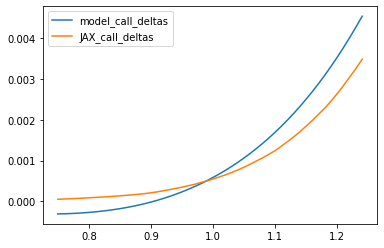

In [31]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.55

def compute_delta(S):
    inputs = torch.tensor([[1, 0.75, B, s1, 0.25, 0.02, 0.02] + [1, 0.75, B, S, 0.25, 0.02, 0.02] + [1, 0.75, B, s3, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([s1, p, s3]) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, 0.75, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

# Comparison on speed

In [32]:
%timeit goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, 0.75, B, T, numpaths)
%timeit compute_delta(1).item()

10 loops, best of 5: 888 ms per loop
The slowest run took 2008.81 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 366 µs per loop
